In [1]:
import pandas as pd
import json

In [3]:
with open("option_columns.json","r") as f:
    option_columns = json.load(f)

#Find the dataset
# df = pd.read_csv("../tuxml-datasets-copie/dataset_encoded.csv", dtype={k:"int8" for k in option_columns})
df = pd.read_csv("../tuxml-datasets-copie/dataset_encoded.csv", dtype={k:"int8" for k in option_columns})

In [4]:
df.shape

(110854, 12638)

In [5]:
df.head()

,104_QUAD_8,21285_WATCHDOG,3C515,53C700_BE_BUS,53C700_LE_ON_BE,60XX_WDT,64BIT,6LOWPAN,6LOWPAN_DEBUGFS,6LOWPAN_GHC_EXT_HDR_DEST,...,ZSWAP,ZX2967_PM_DOMAINS,ZX2967_THERMAL,ZX2967_WATCHDOG,ZX_DMA,ZX_I2S,ZX_SPDIF,ZX_TDM,cid,compile_success
0,1,0,0,0,0,0,0,0,0,0,...,0,1,1,0,1,1,1,1,15000,1
1,1,0,0,0,0,2,0,1,0,1,...,0,0,2,0,2,1,1,1,15001,1
2,1,0,0,0,0,1,0,2,0,1,...,0,0,2,0,2,2,1,2,15002,1
3,1,0,0,0,0,2,0,1,0,1,...,0,0,2,0,1,1,2,2,15003,1
4,1,0,0,0,0,2,0,1,0,1,...,0,1,2,0,1,1,1,1,15004,1


In [6]:
#Only taking configs with cid >= 30000
# df = df[df["cid"] >=30000]

df.query("cid >= 30000", inplace=True)

In [7]:
df.fillna(-1, inplace=True)

In [8]:
df.shape

(96096, 12638)

In [9]:
df.query("(AIC79XX_BUILD_FIRMWARE == 1) | (AIC7XXX_BUILD_FIRMWARE == 1) | (WANXL_BUILD_FIRMWARE == 1)").sort_values(by="cid", ascending=False)[['cid', 'AIC7XXX_BUILD_FIRMWARE', 'AIC79XX_BUILD_FIRMWARE', 'WANXL_BUILD_FIRMWARE']][:10]

,cid,AIC7XXX_BUILD_FIRMWARE,AIC79XX_BUILD_FIRMWARE,WANXL_BUILD_FIRMWARE
110841,126719,0,0,1
72428,88301,1,1,0
70440,86309,0,1,1
70307,86176,0,0,1
70302,86171,0,1,0
70291,86160,0,1,0
70269,86138,0,1,0
70233,86102,0,0,1
70214,86083,1,1,0
70213,86082,0,1,0


In [10]:
len(df.query("compile_success == 0").index)

3622

In [11]:
from sklearn.model_selection import train_test_split
from sklearn import tree

In [12]:
import graphviz

def print_tree(clf, f_names, name):
    
    dot_data = tree.export_graphviz(clf, out_file=None, 
                         feature_names=f_names,  
                         filled=True, rounded=True,
                         special_characters=True)  
    graph = graphviz.Source(dot_data)  
    graph.render(name)

In [13]:
from sklearn.tree import _tree
def tree_to_rules(tree, feature_names):
    tree_ = tree.tree_
    feature_name = [
        feature_names[i] if i != _tree.TREE_UNDEFINED else "undefined!"
        for i in tree_.feature
    ]
    rules = []
    #print ("def tree({}):".format(", ".join(feature_names)))

    def recurse(node, previous_rules):
        if tree_.feature[node] != _tree.TREE_UNDEFINED:
            name = feature_name[node]
            threshold = tree_.threshold[node]
            #print ("{}if {} <= {}:".format(indent, name, threshold))
            recurse(tree_.children_left[node], previous_rules+[name + " <= " + str(threshold)])
            #print ("{}else:  # if {} > {}".format(indent, name, threshold))
            recurse(tree_.children_right[node], previous_rules+[name + " > " + str(threshold)])
        else:
            #print(" & ".join(previous_rules) + " ---> " + str(tree_.value[node]))
            if tree_.value[node][0][0] > tree_.value[node][0][1]:
                rules.append(" & ".join(sorted(previous_rules)))
            #rules.append(" & ".join(previous_rules) + " = " + ("0" if tree_.value[node][0][0] > tree_.value[node][0][1] else "1"))

    recurse(0, [])
    return rules
    

In [14]:
from sklearn.model_selection import ShuffleSplit
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, balanced_accuracy_score, confusion_matrix

rulesTree = {}
metrics = {}

for t_size in [0.999,0.995,0.992,0.99, 0.9, 0.5, 0.1]:
    TESTING_SIZE=t_size # 0.001 
    
    shuffle_split = ShuffleSplit(test_size=TESTING_SIZE, n_splits=10)
    
    acc = []
    prec = []
    reca = []
    f1 = []
    balance_acc = []
    spec = []
    
    for train_index, test_index in shuffle_split.split(df.drop(columns="cid"), df["compile_success"]):
        X_train = df.drop(columns="cid").drop(columns="compile_success").iloc[train_index]
        y_train = df["compile_success"].iloc[train_index]
        X_test = df.drop(columns="cid").drop(columns="compile_success").iloc[test_index]
        y_test = df["compile_success"].iloc[test_index]
        
        
        clf = tree.DecisionTreeClassifier(random_state=0)
        clf.fit(X_train, y_train)
        y_pred = clf.predict(X_test)
        
        acc.append(accuracy_score (y_test, y_pred))
        prec.append(precision_score (y_test, y_pred))
        reca.append(recall_score (y_test, y_pred))
        f1.append(f1_score (y_test, y_pred))
        balance_acc.append(balanced_accuracy_score (y_test, y_pred))
        tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
        spec.append(tn/(tn+fp))
    
    metrics[TESTING_SIZE] = {
        "accuracy" : acc,
        "balanced_accuracy" : balance_acc,
        "specificity" : spec
    }
    
    rulesTree[t_size] = tree_to_rules(clf, df.drop(columns="cid").drop(columns="compile_success").columns)

    print("Testing size : {}".format(t_size))
    print("Accuracy score:", pd.Series(acc).mean())
    print("Precision score:", pd.Series(prec).mean())
    print("Recall score:", pd.Series(reca).mean())
    print("F1 score:", pd.Series(f1).mean())
    print("Balance accuracy score:", pd.Series(balance_acc).mean())
    print("Specificity:", pd.Series(spec).mean())
    print_tree(clf, df.drop(columns="cid").drop(columns="compile_success").columns, "tree_"+str(t_size))
    print()

Testing size : 0.999
Accuracy score: 0.9491885416666668
Precision score: 0.9745691460141899
Recall score: 0.972537839959938
F1 score: 0.9733682968240094
Balance accuracy score: 0.6628374114557234
Specificity: 0.35313698295150886

Testing size : 0.995
Accuracy score: 0.9877761044176706
Precision score: 0.9952258166950063
Recall score: 0.99205548139564
F1 score: 0.9936243822091797
Balance accuracy score: 0.9353112976021801
Specificity: 0.8785671138087204

Testing size : 0.992
Accuracy score: 0.9900386035582409
Precision score: 0.9944300853300424
Recall score: 0.9952210232276297
F1 score: 0.9948239505292917
Balance accuracy score: 0.9264910177096422
Specificity: 0.8577610121916541

Testing size : 0.99
Accuracy score: 0.9933894635048771
Precision score: 0.9968686212569062
Recall score: 0.9962588258473677
F1 score: 0.996560755470747
Balance accuracy score: 0.9582228963157435
Specificity: 0.9201869667841193

Testing size : 0.9
Accuracy score: 0.9959693364320652
Precision score: 0.99855511567

In [15]:
for r_list in rulesTree:
    print(len(rulesTree[r_list]))

1
4
6
4
14
37
49


In [16]:
all_rules = []
for r_list in rulesTree:
    all_rules += rulesTree[r_list]

len(all_rules)

115

In [17]:
len(set(all_rules))

100

In [18]:
rules_by_tsize = {}
for r in set(all_rules):
    rules_by_tsize[r] = {r_list:(r in rulesTree[r_list]) for r_list in rulesTree}

In [19]:
def highlight_truefalse(s):
    return ['background-color: green' if v else 'red' for v in s]

In [20]:
dfRules = pd.DataFrame(rules_by_tsize).T.sort_values([0.99,0.9,0.5,0.1])
dfRules.style.apply(highlight_truefalse)

,0.1,0.5,0.9,0.99,0.992,0.995,0.999
AIC79XX_BUILD_FIRMWARE > 0.5 & AIC7XXX_BUILD_FIRMWARE <= 0.5 & GENERIC_ALLOCATOR > 0.5 & WANXL_BUILD_FIRMWARE <= 0.5,False,False,False,False,False,True,False
AIC79XX_BUILD_FIRMWARE <= 0.5 & AIC7XXX_BUILD_FIRMWARE <= 0.5 & PINCTRL_PALMAS <= 0.5 & POWER_RESET <= 0.5 & WANXL_BUILD_FIRMWARE <= 0.5,False,False,False,False,True,False,False
AIC7XXX_BUILD_FIRMWARE <= 0.5 & WANXL_BUILD_FIRMWARE > 0.5,False,False,False,False,False,True,False
AIC79XX_BUILD_FIRMWARE <= 0.5 & AIC7XXX_BUILD_FIRMWARE <= 0.5 & IP_NF_TARGET_MASQUERADE <= 1.5 & PINCTRL_PALMAS > 0.5 & SND_INDIGOIOX > 1.5 & WANXL_BUILD_FIRMWARE <= 0.5 & XEN_SYMS > 0.5,False,False,False,False,True,False,False
AIC7XXX_BUILD_FIRMWARE <= 0.5 & DRM_VBOXVIDEO > 1.5 & GENERIC_ALLOCATOR <= 0.5 & WANXL_BUILD_FIRMWARE <= 0.5,False,False,False,False,False,True,False
AIC79XX_BUILD_FIRMWARE <= 0.5 & AIC7XXX_BUILD_FIRMWARE <= 0.5 & IP_NF_TARGET_MASQUERADE > 1.5 & PINCTRL_PALMAS > 0.5 & ROMFS_FS > 1.5 & WANXL_BUILD_FIRMWARE <= 0.5,False,False,False,False,True,False,False
AIC7XXX_BUILD_FIRMWARE > 0.5,False,False,False,False,False,True,False
SKY2_DEBUG > 0.5,False,False,False,False,False,False,True
AIC79XX_BUILD_FIRMWARE <= 0.5 & AIC7XXX_BUILD_FIRMWARE <= 0.5 & DRM_VBOXVIDEO <= 1.5 & GENERIC_ALLOCATOR <= 0.5 & HFI1_VERBS_31BIT_PSN <= 0.5 & KERNFS <= 0.5 & PNFS_FLEXFILE_LAYOUT > 0.5 & SYSTEM_BLACKLIST_HASH_LIST > 24259.5 & WANXL_BUILD_FIRMWARE <= 0.5 & WIL6210_TRACING <= 0.5,True,False,False,False,False,False,False
AIC79XX_BUILD_FIRMWARE <= 0.5 & AIC7XXX_BUILD_FIRMWARE <= 0.5 & BLK_DEV_UMEM > 0.5 & BT_HCIUART_NOKIA <= 1.5 & CRC32 > 0.5 & DVB_BUDGET > 1.5 & GENERIC_ALLOCATOR > 0.5 & INPUT_PCSPKR <= 0.5 & NLS > 1.5 & REGULATOR_MAX8997 > 0.5 & RSI_SDIO > 0.5 & SND_SOC_WM8400 > 0.5 & UBSAN_SANITIZE_ALL <= 0.5 & VIDEO_MUX <= 1.5 & WANXL_BUILD_FIRMWARE <= 0.5 & ZLIB_DEFLATE <= 0.5,True,False,False,False,False,False,False


In [21]:
dfMetrics = pd.DataFrame(metrics)
dfMetrics

,0.999,0.995,0.992,0.99,0.9,0.5,0.1
accuracy,"[0.9691041666666667, 0.9689166666666666, 0.983...","[0.9743348393574297, 0.9736550368139224, 0.993...","[0.9908421450151057, 0.9892161799261497, 0.988...","[0.9984653548604103, 0.9970253111335351, 0.986...","[0.996554395458277, 0.9956756506758241, 0.9947...","[0.9984182484182484, 0.9982517482517482, 0.997...","[0.9990634755463059, 0.9987513007284079, 0.998..."
balanced_accuracy,"[0.7249568467938645, 0.7277062652790043, 0.786...","[0.920281051504019, 0.9193742582439035, 0.9287...","[0.9272782307863143, 0.9269713657435448, 0.926...","[0.9798276394964969, 0.9792689424465201, 0.925...","[0.980100934411851, 0.9801380502609831, 0.9800...","[0.9882767776393275, 0.9913447621163092, 0.987...","[0.9939497913484481, 0.9879848635116513, 0.988..."
specificity,"[0.46090080132633326, 0.46683250414593697, 0.5...","[0.8618201997780244, 0.860678531701891, 0.8586...","[0.8585352269562796, 0.8596442468037799, 0.858...","[0.9596662030598053, 0.9600670203853672, 0.858...","[0.9623046276432731, 0.963339494762785, 0.9640...","[0.9773104593248478, 0.9838987924094307, 0.975...","[0.9884393063583815, 0.976401179941003, 0.9775..."


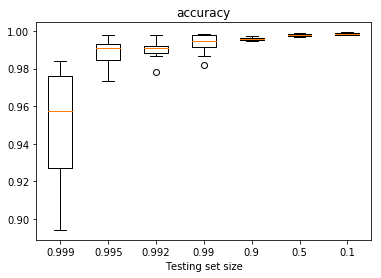

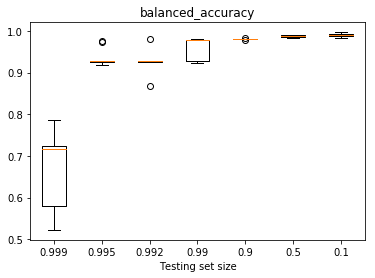

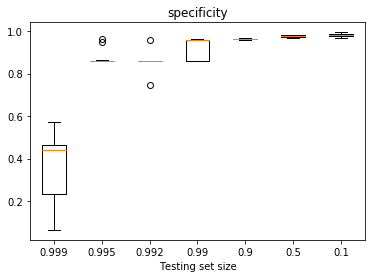

In [33]:
import matplotlib.pyplot as plt

tsize = [m for m in metrics]

for metric in ["accuracy","balanced_accuracy","specificity"]:
    data = [metrics[m][metric] for m in metrics]

    plt.boxplot(data, labels=tsize)
    plt.title(metric)
    plt.xlabel('Testing set size')

    plt.show()